# Tutorial 9

### Today's Topic:
* Big picture of the ANI project
* Understanding the data structure of ANI dataset
* Implementing atomic environment vector (AEV) calculator in ANI models with numpy
* ModuleDict
* Q&A on HW8

### References
* ANI-1: an extensible neural network potential with DFT accuracy at force field computational cost<br> ([Article](https://pubs.rsc.org/en/content/articlepdf/2017/sc/c6sc05720a), [SI](http://www.rsc.org/suppdata/c6/sc/c6sc05720a/c6sc05720a1.pdf), [Dataset](https://doi.org/10.6084/m9.figshare.c.3846712.v1)),


## Understanding data organization

Adapted from example_data_sampler.py

In [5]:
import pyanitools as pya

# Set the HDF5 file containing the data
hdf5file = '../../final_project/ANI-1_release/ani_gdb_s01.h5'

# Construct the data loader class
adl = pya.anidataloader(hdf5file)

# Print the species of the data set one by one
for data in adl:
#     print(data.keys())

    # Extract the data
    P = data['path']
    X = data['coordinates']
    E = data['energies']
    S = data['species']
    sm = data['smiles']

    # Print the data
    print("Path:   ", P)
    print("  Smiles:      ","".join(sm))
    print("  Symbols:     ", S)
    print("  Coordinates: ", X.shape)
    print("  Energies:    ", E.shape, "\n")

# Closes the H5 data file
adl.cleanup()

Path:    /gdb11_s01/gdb11_s01-0
  Smiles:       [H]C([H])([H])[H]
  Symbols:      ['C', 'H', 'H', 'H', 'H']
  Coordinates:  (5400, 5, 3)
  Energies:     (5400,) 

Path:    /gdb11_s01/gdb11_s01-1
  Smiles:       [H]N([H])[H]
  Symbols:      ['N', 'H', 'H', 'H']
  Coordinates:  (3600, 4, 3)
  Energies:     (3600,) 

Path:    /gdb11_s01/gdb11_s01-2
  Smiles:       [H]O[H]
  Symbols:      ['O', 'H', 'H']
  Coordinates:  (1800, 3, 3)
  Energies:     (1800,) 



### Use Iterator to get data

In [24]:
from pyanitools import anidataloader
# data = anidataloader("../../ANI1_dataset/ANI-1_release/ani_gdb_s07.h5")
data = anidataloader("../../final_project/ANI-1_release/ani_gdb_s05.h5")
data_iter = data.__iter__()

/Users/nancy/Desktop/academics/teaching 2022 Spring/chem195:295/Tutorials/Tutorial 9/pyanitools.py:47: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.store = h5py.File(store_file)


In [25]:
mols = next(data_iter)
# Extract the data
P = mols['path']
X = mols['coordinates']
E = mols['energies']
S = mols['species']
sm = mols['smiles']

# Print the data
print("Path:   ", P)
print("  Smiles:      ","".join(sm))
print("  Symbols:     ", S)
print("  Coordinates: ", X.shape)
print("  Energies:    ", E.shape, "\n")


Path:    /gdb11_s05/gdb11_s05-0
  Smiles:       [H]N([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
  Symbols:      ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
  Coordinates:  (10080, 16, 3)
  Energies:     (10080,) 



/Users/nancy/Desktop/academics/teaching 2022 Spring/chem195:295/Tutorials/Tutorial 9/pyanitools.py:59: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dataset = np.array(item[k].value)


How many molecules and conformations are there?

In [15]:
data_iter = data.__iter__()
count=0
count_conf =0
for mol in data_iter:
    count+=1
    count_conf += len(mol['energies'])
print(count)
print(count_conf)

/Users/nancy/Desktop/academics/teaching 2022 Spring/chem195:295/Tutorials/Tutorial 9/pyanitools.py:59: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dataset = np.array(item[k].value)


267
1813151


## AEV and implementation


### Understanding symmetric functions
Requirements for the representation of atomic environments:
1. Translational invariance
2. Rotational invariance
3. Atomic permutation invariance
![](molecule.jpg)

#### Distance conversion function
$$
f_{\mathrm{C}}\left(R_{i j}\right)=\left\{\begin{array}{cl}0.5 \times \cos \left(\frac{\pi R_{i j}}{R_{\mathrm{C}}}\right)+0.5 & \text { for } R_{i j} \leq R_{\mathrm{C}} \\ 0.0 & \text { for } R_{i j}>R_{\mathrm{C}}\end{array}\right.
$$
Free parameter: $R_C$

Literature values: 
* Radial cutoff   $R_C^{radial}=5.2Å$
* Angular cutoff $R_C^{angular}=3.5Å$

#### Radial environment components
$$
G_{m}^{\mathrm{R}}=\sum_{j \neq i}^{\text {all atoms }} \mathrm{e}^{-\eta\left(R_{i j}-R_{s}\right)^{2}} f_{\mathrm{C}}\left(R_{i j}\right)
$$
Free parameters: $\{\eta, R_s\}$

Literature values:
* $\eta^{radial}=16$
* $R_s^{radial}\in\{0.900000, 1.168750, 1.437500, 1.706250, 1.975000, 2.243750, 2.51250,
 2.781250, 3.050000, 3.318750, 3.587500, 3.856250, 4.125000, 4.39375,
4.662500, 4.931250\}Å$

#### Angular environment components
$$
G_{m}^{A_{\text {mod }}}=2^{1-\zeta} \sum_{j, k \neq i}^{\text {all atoms }}\left(1+\cos \left(\theta_{i j k}-\theta_{s}\right)\right)^{\zeta} \times \exp \left[-\eta\left(\frac{R_{i j}+R_{i k}}{2}-R_{s}\right)^{2}\right] f_{\mathrm{C}}\left(R_{i j}\right) f_{\mathrm{C}}\left(R_{i k}\right)
$$<br>
Free parameters: $\{\zeta, \theta_s, \eta, R_s\}$

Literature values:
* $\zeta=32$
* $\theta_s \in \{0.19634954, 0.58904862,0. 9817477, 1.3744468, 1.7671459,
2.1598449, 2.552544, 2.945243\}$
* $\eta^{angular}=8$
* $R_s^{angular}\in\{0.900000, 1.550000, 2.200000, 2.850000\}Å$

In [22]:
import numpy as np


def calc_f_C(Rij, RC):
    f_C_value = 0.5 * np.cos(np.pi * Rij / RC) + 0.5
    indicator = ((Rij <= RC) & (Rij != 0)).astype(float) # Make f_C(0)=0 to make sure the sum in distance conversion function and radial conversion function can run with j=i
    return f_C_value * indicator

def radial_component(Rijs, eta, Rs, RC=5.2):
    # Rijs is a 1d array, all other parameters are scalars
    f_C_values = calc_f_C(Rijs, RC)
    individual_components = np.exp(-eta * (Rijs - Rs) ** 2) * f_C_values
    return np.sum(individual_components)

def angular_component(Rij_vectors, Rik_vectors, zeta, theta_s, eta, Rs, RC=3.5):
    # Rij_vectors and Rik_vectors are 2d arrays with shape (n_atoms, 3), all other parameters are scalars
    # calculate theta_ijk values from vector operations
    dot_products = Rij_vectors.dot(Rik_vectors.T)
    Rij_norms = np.linalg.norm(Rij_vectors, axis=-1)
    Rik_norms = np.linalg.norm(Rik_vectors, axis=-1)
    norms = Rij_norms.reshape((-1, 1)).dot(Rik_norms.reshape((1, -1)))
    cos_values = np.clip(dot_products / (norms + 1e-8), -1, 1)
    theta_ijks = np.arccos(cos_values)
    theta_ijk_filter = (theta_ijks != 0).astype(float)
    mean_dists = (Rij_norms.reshape((-1, 1)) + Rik_norms.reshape((1, -1))) / 2
    f_C_values_Rij = calc_f_C(Rij_norms, RC)
    f_C_values_Rik = calc_f_C(Rik_norms, RC)
    f_C_values = f_C_values_Rij.reshape((-1, 1)).dot(f_C_values_Rik.reshape((1, -1)))
    individual_components = (1 + np.cos(theta_ijks - theta_s)) ** zeta * np.exp(-eta * (mean_dists - Rs) ** 2) * f_C_values * theta_ijk_filter
    return 2 ** (1 - zeta) * np.sum(individual_components)

def calc_aev(atom_types, coords, i_index):
    # atom_types are np.array of ints
    relative_coordinates = coords - coords[i_index]
    nearby_atom_indicator = np.linalg.norm(relative_coordinates, axis=-1) < 5.3
    relative_coordinates = relative_coordinates[nearby_atom_indicator]
    atom_types = atom_types[nearby_atom_indicator]
    radial_aev = np.array([radial_component(np.linalg.norm(relative_coordinates[atom_types == atom], axis=-1), eta, Rs) \
                           for atom in [0, 1, 2, 3] for eta in [16] \
                           for Rs in [0.900000,1.168750,1.437500,1.706250,1.975000,2.243750,2.51250,2.781250,3.050000,\
                                   3.318750,3.587500,3.856250,4.125000,4.39375,4.662500,4.931250]])
    angular_aev = np.array([angular_component(relative_coordinates[atom_types == atom_j], relative_coordinates[atom_types == atom_k],\
                                             zeta, theta_s, eta, Rs) \
                            for atom_j in [0, 1, 2, 3] for atom_k in range(atom_j, 4) for zeta in [32] \
                            for theta_s in [0.19634954,0.58904862,0.9817477,1.3744468,1.7671459,2.1598449,2.552544,2.945243]\
                            for eta in [8] for Rs in [0.900000,1.550000,2.200000,2.850000]])
    print(len(radial_aev), len(angular_aev))
    return np.concatenate([radial_aev, angular_aev])

        

### Distance Conversion function

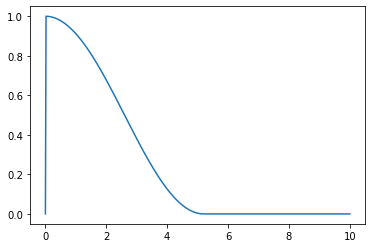

In [21]:
import numpy as np
import matplotlib.pyplot as plt
r_ij = np.linspace(0,10,500)
rc = 5.2
plt.plot(r_ij,[calc_f_C(r,rc)for r in r_ij])

### Visualizing AEVs

In [23]:
mapping={"H":0, "C":1, "N":2, "O":3}

In [26]:
elements= np.array([mapping[atom] for atom in S])
elements

array([1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

Let's plot the AEV for the same atom in different conformation

64 320
64 320


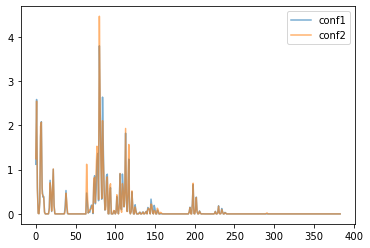

In [28]:
plt.plot(calc_aev(elements,X[1],2), label="conf1", alpha=0.6)
plt.plot(calc_aev(elements,X[2],2), label="conf2", alpha=0.6)
plt.legend()

## Network as a sum of sub-networks using ModuleDict

In [ ]:
class ANI(nn.Module):
    def __init__(self):
        super().__init__()
        self.sub_nets = nn.ModuleDict({"C": ANI_sub([architecture]), "H": ANI_sub([architecture],...)})

    def forward(self, aevs, atom_types):
        atomic_energies = ...
        
        total_energies = torch.sum(atomic_energies,dim=...)
        return total_eneirgies

class ANI_sub(nn.Module):
    def __init__(self, architecture):
        super().__init__()
        ...

    def forward(self, aev):
        atomic_energy = ...
        return atomic_energy


## General suggestions for final project
* Test the workflow on small amount of data first
* Tuning hyperparameters and finalizing architecture with a little more data.
* Final production run on full data ( to be defined based on resource to be provided)
* Save intermediate result! (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
